In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats
from sklearn.metrics import pairwise_distances

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
use_cuda=True
datadir='/media/xinyi/dcis2idc/data'
name='exp0'
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name
sampledir=plotsavepath
clustersavedir_alltrain=os.path.join(sampledir,'cluster_alltrain_reordered')
ep=311
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s
    




In [3]:
metadata=pd.read_csv(os.path.join(datadir,'Supplementary Table 1_v1.csv'),header=0)
metadata.index=metadata.sample_id

In [4]:
allPatientIDs=np.repeat('none',allImgNames.size).astype(object)
for s in np.unique(allImgNames):
    sidx=allImgNames==s
    slideID=s.split('_')[0]
    coreID=s.split('_')[-1]
    allPatientIDs[sidx]=metadata.patient_id[slideID+'_'+str.lower(coreID)]

In [5]:
savenamesample='alltrain'

neworder=[1, 5, 3, 7, 2, 0, 4, 6]
#use chosen subcluster number and save plots
scanpy.settings.verbosity = 3
# subcluster=8
subclusterDict={0:[4],1:[6],2:[8],3:[6],4:[6],5:[6],6:[6],7:[4]}
ncluster=8

plotepoch=311
clusterplotdir=os.path.join(clustersavedir_alltrain,'plots')
n_pcs=50
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
with open(os.path.join(clustersavedir_alltrain,'minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
    clusterRes=pickle.load(output)

kmeans_sub=(np.zeros(clusterRes.size)-1).astype(str)
savenameAdd='_plottingIdx_progBalanced_'+str(0)
subclusternumbers=[4,6,8,6,6,6,6,4]
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
for cnew in np.unique(clusterRes):
#     print('cluster'+str(c))
    c=neworder[cnew]
    
    subclustersavedir_alltrain=os.path.join(clustersavedir_alltrain,savenamecluster+'_subcluster'+str(c))
    with open(os.path.join(subclustersavedir_alltrain,'minibatchkmean_ncluster'+str(subclusternumbers[c])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    print(np.unique(subclusterRes))
    kmeans_sub[clusterRes==cnew]=np.char.add(np.repeat(str(cnew)+'-',subclusterRes.size),subclusterRes.astype(str))
   

[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3]
[0 1 2 3 4 5 6 7]
[0 1 2 3]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


In [6]:
with open(os.path.join(datadir,'processed','train_cnnvae_coord'), 'rb') as output:
    coordlist=pickle.load(output)

In [7]:
for p in np.unique(progList):
    if p=='Ductal carcinoma in situ':
        progList[progList==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList[progList==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltratio':
        progList[progList==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ wi':
        progList[progList==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia': #wrong name; not counted
#         progList[progList==p]='Hyperplasia'

In [10]:
progInclude=np.array(['Breast tissue','Cancer adjacent normal breast tissue','Hyperplasia','DCIS and breast tissue',
                     'DCIS with early infiltration','Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma'])

In [11]:
progIncludeIdx=np.repeat(False,progList.size)
for p in progInclude:
    progIncludeIdx[progList==p]=True
    
coordlist=coordlist[progIncludeIdx]
allImgNames=allImgNames[progIncludeIdx]
clusterRes=clusterRes[progIncludeIdx]
kmeans_sub=kmeans_sub[progIncludeIdx]
progList=progList[progIncludeIdx]

In [12]:
sUnique,sidx_start=np.unique(allImgNames,return_index=True)
progUnique,labels_train,progCounts=np.unique(progList[sidx_start],return_counts=True,return_inverse=True)
for p in range(progUnique.size):
    print(progUnique[p])
    print(progCounts[p])

Breast tissue
20
Cancer adjacent normal breast tissue
13
DCIS and breast tissue
16
DCIS with early infiltration
30
Hyperplasia
41
Invasive ductal carcinoma
70
Invasive ductal carcinoma and breast tissue
8


In [13]:
def getHistMatrix_clusters(labels,ctlist,nrow=ncluster,ncol=ncluster):
    res=np.zeros((nrow,ncol))
    for li in range(res.shape[0]):
        l=li
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ci
            res[l,c]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
        if nl!=0:
            res[li]=res[li]/nl
    return res

neighborhoodSize=16*9

In [14]:
#get neighborhood composition

inputNeighborhood=np.zeros((sUnique.size,ncluster*ncluster))
for i in range(sUnique.size):
    imgN=sUnique[i]
    nsamples=np.sum(allImgNames==imgN)
    cluster_i=clusterRes[allImgNames==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist[allImgNames==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood[i]=res.flatten()

In [15]:
_,inputCounts=np.unique(allImgNames,return_counts=True)
inputAll_train=np.concatenate((inputNeighborhood,inputCounts.reshape(-1,1)),axis=1)

In [16]:
#val cores (as validation cores) and val samples (as test cores)
clustersavedir_valcores=os.path.join(sampledir,'cluster_valcores_reordered')
clustersavedir_valsamples=os.path.join(sampledir,'cluster_valsamples_reordered')

with open(os.path.join(datadir,'processed','train_cnnvae_coord_valcores'), 'rb') as output:
    coordlist_valcores=pickle.load(output)
with open(os.path.join(datadir,'processed','train_cnnvae_coord_valsamples'), 'rb') as output:
    coordlist_valsamples=pickle.load(output)

savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
with open(os.path.join(clustersavedir_valcores,savenamecluster+'_all'), 'rb') as output:
    clusterRes_valcores=pickle.load(output)
with open(os.path.join(clustersavedir_valsamples,'minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
    clusterRes_valsamples=pickle.load(output)
    
kmeans_sub_valcores=(np.zeros(clusterRes_valcores.size)-1).astype(str)
for c in np.unique(clusterRes_valcores):
    subclustersavedir=os.path.join(clustersavedir_valcores,savenamecluster+'_plottingIdx_progBalanced_'+str(0)+'_subcluster'+str(neworder[c]))
    with open(os.path.join(subclustersavedir,'minibatchkmean_ncluster'+str(subclusterDict[neworder[c]][0])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    kmeans_sub_valcores[clusterRes_valcores==c]=np.char.add(np.repeat(str(c)+'-',subclusterRes.size),subclusterRes.astype(str))
    
kmeans_sub_valsamples=(np.zeros(clusterRes_valsamples.size)-1).astype(str)
for c in np.unique(clusterRes_valsamples):
    subclustersavedir=os.path.join(clustersavedir_valsamples,savenamecluster+'_plottingIdx_progBalanced_'+str(0)+'_subcluster'+str(neworder[c]))
    with open(os.path.join(subclustersavedir,'minibatchkmean_ncluster'+str(subclusterDict[neworder[c]][0])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    kmeans_sub_valsamples[clusterRes_valsamples==c]=np.char.add(np.repeat(str(c)+'-',subclusterRes.size),subclusterRes.astype(str))
                

In [17]:
with open(os.path.join(datadir,'processed','train_cnnvae_names_valcores'), 'rb') as input:
    allImgNames_valcores=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_names_valsamples'), 'rb') as input:
    allImgNames_valsamples=pickle.load(input)

In [18]:
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList_valcores=np.copy(allImgNames_valcores)
for s in np.unique(allImgNames_valcores):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList_valcores[allImgNames_valcores==s]=prog_s
    
progList_valsamples=np.copy(allImgNames_valsamples)
for s in np.unique(allImgNames_valsamples):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList_valsamples[allImgNames_valsamples==s]=prog_s
    



In [19]:
for p in np.unique(progList_valcores):
    if p=='Ductal carcinoma in situ':
        progList_valcores[progList_valcores==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList_valcores[progList_valcores==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltratio':
        progList_valcores[progList_valcores==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ wi':
        progList_valcores[progList_valcores==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia':
#         progList_valcores[progList_valcores==p]='Hyperplasia'

In [20]:
for p in np.unique(progList_valsamples):
    if p=='Ductal carcinoma in situ':
        progList_valsamples[progList_valsamples==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList_valsamples[progList_valsamples==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltrati':
        progList_valsamples[progList_valsamples==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ w':
        progList_valsamples[progList_valsamples==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia':
#         progList_valsamples[progList_valsamples==p]='Hyperplasia'

In [21]:
progIncludeIdx_valcores=np.repeat(False,progList_valcores.size)
for p in progInclude:
    progIncludeIdx_valcores[progList_valcores==p]=True
    
progIncludeIdx_valsamples=np.repeat(False,progList_valsamples.size)
for p in progInclude:
    progIncludeIdx_valsamples[progList_valsamples==p]=True
    
coordlist_valcores=coordlist_valcores[progIncludeIdx_valcores]
allImgNames_valcores=allImgNames_valcores[progIncludeIdx_valcores]
clusterRes_valcores=clusterRes_valcores[progIncludeIdx_valcores]
kmeans_sub_valcores=kmeans_sub_valcores[progIncludeIdx_valcores]
progList_valcores=progList_valcores[progIncludeIdx_valcores]

coordlist_valsamples=coordlist_valsamples[progIncludeIdx_valsamples]
allImgNames_valsamples=allImgNames_valsamples[progIncludeIdx_valsamples]
clusterRes_valsamples=clusterRes_valsamples[progIncludeIdx_valsamples]
kmeans_sub_valsamples=kmeans_sub_valsamples[progIncludeIdx_valsamples]
progList_valsamples=progList_valsamples[progIncludeIdx_valsamples]


In [22]:
sUnique_valcores,sidx_start_valcores=np.unique(allImgNames_valcores,return_index=True)
progUnique_valcores,progCounts_valcores=np.unique(progList_valcores[sidx_start_valcores],return_counts=True)
for p in range(progUnique_valcores.size):
    print(progUnique_valcores[p])
    print(progCounts_valcores[p])

Breast tissue
20
Cancer adjacent normal breast tissue
1
Hyperplasia
35
Invasive ductal carcinoma
97


In [23]:
sUnique_valsamples,sidx_start_valsamples=np.unique(allImgNames_valsamples,return_index=True)
progUnique_valsamples,progCounts_valsamples=np.unique(progList_valsamples[sidx_start_valsamples],return_counts=True)
for p in range(progUnique_valsamples.size):
    print(progUnique_valsamples[p])
    print(progCounts_valsamples[p])

Breast tissue
14
Cancer adjacent normal breast tissue
4
DCIS and breast tissue
16
DCIS with early infiltration
29
Hyperplasia
25
Invasive ductal carcinoma
66
Invasive ductal carcinoma and breast tissue
8


In [24]:
#construct labels
labels_valcores=np.zeros(progList_valcores[sidx_start_valcores].size)
for i in range(progUnique.size):
    labels_valcores[progList_valcores[sidx_start_valcores]==progUnique[i]]=i

In [25]:
#construct labels
labels_valsamples=np.zeros(progList_valsamples[sidx_start_valsamples].size)
for i in range(progUnique.size):
    labels_valsamples[progList_valsamples[sidx_start_valsamples]==progUnique[i]]=i

In [26]:
inputNeighborhood_valcores=np.zeros((sUnique_valcores.size,ncluster*ncluster))
for i in range(sUnique_valcores.size):
    imgN=sUnique_valcores[i]
    nsamples=np.sum(allImgNames_valcores==imgN)
    cluster_i=clusterRes_valcores[allImgNames_valcores==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist_valcores[allImgNames_valcores==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood_valcores[i]=res.flatten()

In [28]:
inputNeighborhood_valsamples=np.zeros((sUnique_valsamples.size,ncluster*ncluster))
for i in range(sUnique_valsamples.size):
    imgN=sUnique_valsamples[i]
    nsamples=np.sum(allImgNames_valsamples==imgN)
    cluster_i=clusterRes_valsamples[allImgNames_valsamples==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist_valsamples[allImgNames_valsamples==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood_valsamples[i]=res.flatten()

In [29]:
_,inputCounts_valcores=np.unique(allImgNames_valcores,return_counts=True)
inputAll_valcores=np.concatenate((inputNeighborhood_valcores,inputCounts_valcores.reshape(-1,1)),axis=1)

In [30]:
_,inputCounts_valsamples=np.unique(allImgNames_valsamples,return_counts=True)
inputAll_valsamples=np.concatenate((inputNeighborhood_valsamples,inputCounts_valsamples.reshape(-1,1)),axis=1)

In [31]:
#concatenate cores
inputAll=np.concatenate((inputAll_train,np.concatenate((inputAll_valcores,inputAll_valsamples),axis=0)),axis=0)
imgNamesAll=np.concatenate((allImgNames[sidx_start],np.concatenate((allImgNames_valcores[sidx_start_valcores],allImgNames_valsamples[sidx_start_valsamples]))))
labelsAll=np.concatenate((labels_train,np.concatenate((labels_valcores,labels_valsamples))))

In [32]:
_,progCountsAll=np.unique(labelsAll,return_counts=True)
weights_train=np.sum(progCountsAll)/progCountsAll

In [33]:
clusterResAll=np.concatenate((clusterRes[sidx_start],np.concatenate((clusterRes_valcores[sidx_start_valcores],clusterRes_valsamples[sidx_start_valsamples]))))

In [34]:
#normalize count
with open(os.path.join(datadir,'processed','imgSizeByPath'), 'rb') as output:
    imgSize_median=pickle.load(output)
areaAll=np.zeros(labelsAll.size)
for s in range(labelsAll.size):
    areaAll[s]=imgSize_median[progUnique[labelsAll.astype(int)][s]]
inputAll[:,-1]=inputAll[:,-1]/areaAll

In [35]:
seed=3
epochs=6000
saveFreq=200
lr=0.001 #initial learning rate
weight_decay=0 

# batchsize=4
batchsize=6000
model_str='fc3'

fc_dim1=64
fc_dim2=64
fc_dim3=64


dropout=0.01

name='exp0_pathologyClf_neighbor_clusters_exp0_subset_neighborOnly_crossVal_ablation_countAreaNorm_byPatient'
logsavepath='/media/xinyi/dcis2idc/log/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)



In [36]:
def train(epoch,trainInput,labels_train):
    t = time.time()
    model.train()
    optimizer.zero_grad()

    pred = model(trainInput)

    loss=lossCE(pred,labels_train)

    loss.backward()
    optimizer.step()

    if epoch%500==0:
        print('Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss))
    return loss.item()

In [37]:

labelsAll=torch.tensor(labelsAll).cuda().long()

In [38]:
pIDList=allPatientIDs[np.concatenate((sidx_start,np.concatenate((sidx_start_valcores,sidx_start_valsamples))))]


In [39]:
#plot confusion
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',order=progInclude):
    res=np.zeros((order.size,order.size))
    for li in range(res.shape[0]):
        l=order[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=order[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=order[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=order[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
    fig.colorbar(im)
    ax.set_yticks(np.arange(order.size))
    ax.set_yticklabels(order)
    ax.set_xticks(np.arange(order.size))
    ax.set_xticklabels(order)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    


In [42]:
for c in np.unique(clusterResAll):
# for c in [5,6,7]:
    print('cluster'+str(c))
    mask=np.repeat(True,64).reshape(8,8)
    mask[c]=False
    mask[:,c]=False
    mask=np.concatenate((mask.flatten(),[True]))
    inputAll_c=np.copy(inputAll[:,mask])
    
    nc=np.unique(clusterResAll).size-1
    for ci in range(nc):
        inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)
    inputAll_c[np.logical_not(np.isfinite(inputAll_c))]=0
    
    if not os.path.exists(os.path.join(modelsavepath,str(c))):
        os.mkdir(os.path.join(modelsavepath,str(c)))
    if not os.path.exists(os.path.join(logsavepath,str(c))):
        os.mkdir(os.path.join(logsavepath,str(c)))
    if not os.path.exists(os.path.join(plotsavepath,str(c))):
        os.mkdir(os.path.join(plotsavepath,str(c)))
    
    inputAll_c=scipy.stats.zscore(inputAll_c,axis=0)
    inputAll_c=torch.tensor(inputAll_c).cuda().float()
    
    testepoch=4800
    predtest=np.zeros((inputAll_c.shape[0],np.unique(labels_train).size))
    for patientIDX in range(np.unique(pIDList).size):
        patientID=np.unique(pIDList)[patientIDX]
        print(patientID)
        sampleIdx=np.arange(inputAll.shape[0])[pIDList==patientID]
        trainIdx=np.arange(inputAll.shape[0])[pIDList!=patientID]
        
        seed=3
        torch.manual_seed(seed)
        nclasses=np.unique(labels_train).size
        if use_cuda:
            torch.cuda.manual_seed(seed)

        nfeatures=inputAll_c.shape[1]
        if model_str=='fc3':
            model = modelsCNN.FC_l3(nfeatures,fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc5':
            model = modelsCNN.FC_l5(nfeatures,fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc1':
            model = modelsCNN.FC_l1(nfeatures,fc_dim1,nclasses,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc0':
            model = modelsCNN.FC_l0(nfeatures,nclasses,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())

        if use_cuda:
            model.cuda()

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        train_loss_ep=[None]*epochs
        val_loss_ep=[None]*epochs
        t_ep=time.time()

#         if os.path.exists(os.path.join(modelsavepath,str(c),patientID+'_'+str(testepoch)+'.pt')):
#             model.load_state_dict(torch.load(os.path.join(modelsavepath,str(c),patientID+'_'+str(testepoch)+'.pt')))
#             with torch.no_grad():
#                 model.cuda()
#                 model.eval()
#                 pred = model(inputAll_c[[sampleIdx]])
#                 predtest[sampleIdx]=pred.cpu().detach().numpy()

#                 loss_test=lossCE(pred,labelsAll[[sampleIdx]]).item()
#             continue
            
            
        for ep in range(epochs):
            train_loss_ep[ep]=train(ep,inputAll_c[trainIdx],labelsAll[trainIdx])


            if ep%saveFreq == 0 and ep!=0:
                torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(c),patientID+'_'+str(ep)+'.pt'))
            if use_cuda:
                model.cuda()
                torch.cuda.empty_cache()
        print(' total time: {:.4f}s'.format(time.time() - t_ep))

        with open(os.path.join(logsavepath,str(c),patientID+'_train_loss'), 'wb') as output:
            pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)

        model.load_state_dict(torch.load(os.path.join(modelsavepath,str(c),patientID+'_'+str(testepoch)+'.pt')))
        with torch.no_grad():
            model.cuda()
            model.eval()
            pred = model(inputAll_c[sampleIdx])
            predtest[sampleIdx]=pred.cpu().detach().numpy()

            loss_test=lossCE(pred,labelsAll[sampleIdx]).item()

        print(loss_test)

    with open(os.path.join(logsavepath,str(c),'crossVal_loss'), 'wb') as output:
        pickle.dump(predtest, output, pickle.HIGHEST_PROTOCOL)

    predtest_label=np.argmax(predtest,axis=1)
    res=pd.DataFrame({'sampleName':imgNamesAll,'true':progUnique[labelsAll.cpu().numpy()],'predicted':progUnique[predtest_label]})
    res.to_csv(os.path.join(plotsavepath,str(c),'predictions.csv'))

    plotCTcomp(progUnique[labelsAll.cpu().numpy()],progUnique[predtest_label],os.path.join(plotsavepath,str(c)),'confusion'+str(testepoch),False)

cluster0
fmg010001
Epoch: 0000 loss_train: 1.9614


<ipython-input-42-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.4874
Epoch: 1000 loss_train: 0.3111
Epoch: 1500 loss_train: 0.2146
Epoch: 2000 loss_train: 0.1971
Epoch: 2500 loss_train: 0.1717
Epoch: 3000 loss_train: 0.1172
Epoch: 3500 loss_train: 0.1289
Epoch: 4000 loss_train: 0.1151
Epoch: 4500 loss_train: 0.1085
Epoch: 5000 loss_train: 0.1140
Epoch: 5500 loss_train: 0.0665
 total time: 12.2740s
0.15449857711791992
fmg010016
Epoch: 0000 loss_train: 1.9577
Epoch: 0500 loss_train: 0.5054
Epoch: 1000 loss_train: 0.3199
Epoch: 1500 loss_train: 0.1781
Epoch: 2000 loss_train: 0.1675
Epoch: 2500 loss_train: 0.1607
Epoch: 3000 loss_train: 0.1286
Epoch: 3500 loss_train: 0.1396
Epoch: 4000 loss_train: 0.1227
Epoch: 4500 loss_train: 0.1107
Epoch: 5000 loss_train: 0.0979
Epoch: 5500 loss_train: 0.1446
 total time: 10.6455s
0.0
fmg010027
Epoch: 0000 loss_train: 1.9627
Epoch: 0500 loss_train: 0.5114
Epoch: 1000 loss_train: 0.2941
Epoch: 1500 loss_train: 0.2094
Epoch: 2000 loss_train: 0.1636
Epoch: 2500 loss_train: 0.2002
Epoch: 3000 l

Epoch: 3500 loss_train: 0.1342
Epoch: 4000 loss_train: 0.1429
Epoch: 4500 loss_train: 0.1104
Epoch: 5000 loss_train: 0.0969
Epoch: 5500 loss_train: 0.0946
 total time: 11.9732s
0.045116301625967026
fmg020034
Epoch: 0000 loss_train: 1.9550
Epoch: 0500 loss_train: 0.5381
Epoch: 1000 loss_train: 0.2963
Epoch: 1500 loss_train: 0.1548
Epoch: 2000 loss_train: 0.1817
Epoch: 2500 loss_train: 0.1869
Epoch: 3000 loss_train: 0.1457
Epoch: 3500 loss_train: 0.1493
Epoch: 4000 loss_train: 0.1089
Epoch: 4500 loss_train: 0.0874
Epoch: 5000 loss_train: 0.1306
Epoch: 5500 loss_train: 0.1112
 total time: 12.3725s
0.35416916012763977
fmg020088
Epoch: 0000 loss_train: 1.9522
Epoch: 0500 loss_train: 0.5534
Epoch: 1000 loss_train: 0.3251
Epoch: 1500 loss_train: 0.2379
Epoch: 2000 loss_train: 0.1290
Epoch: 2500 loss_train: 0.1462
Epoch: 3000 loss_train: 0.1625
Epoch: 3500 loss_train: 0.0893
Epoch: 4000 loss_train: 0.0807
Epoch: 4500 loss_train: 0.0947
Epoch: 5000 loss_train: 0.1390
Epoch: 5500 loss_train: 0.1

Epoch: 0500 loss_train: 0.5015
Epoch: 1000 loss_train: 0.2678
Epoch: 1500 loss_train: 0.2238
Epoch: 2000 loss_train: 0.1579
Epoch: 2500 loss_train: 0.1325
Epoch: 3000 loss_train: 0.0959
Epoch: 3500 loss_train: 0.1376
Epoch: 4000 loss_train: 0.0964
Epoch: 4500 loss_train: 0.1038
Epoch: 5000 loss_train: 0.0756
Epoch: 5500 loss_train: 0.0879
 total time: 9.8015s
9.571276664733887
fmg041195
Epoch: 0000 loss_train: 1.9567
Epoch: 0500 loss_train: 0.5095
Epoch: 1000 loss_train: 0.2795
Epoch: 1500 loss_train: 0.2296
Epoch: 2000 loss_train: 0.1897
Epoch: 2500 loss_train: 0.1477
Epoch: 3000 loss_train: 0.1367
Epoch: 3500 loss_train: 0.0788
Epoch: 4000 loss_train: 0.1222
Epoch: 4500 loss_train: 0.0867
Epoch: 5000 loss_train: 0.0969
Epoch: 5500 loss_train: 0.1402
 total time: 9.2487s
23.194467544555664
fmg041208
Epoch: 0000 loss_train: 1.9570
Epoch: 0500 loss_train: 0.5511
Epoch: 1000 loss_train: 0.3037
Epoch: 1500 loss_train: 0.2594
Epoch: 2000 loss_train: 0.1466
Epoch: 2500 loss_train: 0.1608
Ep

Epoch: 3500 loss_train: 0.1313
Epoch: 4000 loss_train: 0.1167
Epoch: 4500 loss_train: 0.1058
Epoch: 5000 loss_train: 0.1325
Epoch: 5500 loss_train: 0.0724
 total time: 11.4913s
11.68126106262207
fmg150390
Epoch: 0000 loss_train: 1.9509
Epoch: 0500 loss_train: 0.5334
Epoch: 1000 loss_train: 0.2863
Epoch: 1500 loss_train: 0.2371
Epoch: 2000 loss_train: 0.1546
Epoch: 2500 loss_train: 0.1536
Epoch: 3000 loss_train: 0.1342
Epoch: 3500 loss_train: 0.1057
Epoch: 4000 loss_train: 0.1488
Epoch: 4500 loss_train: 0.0792
Epoch: 5000 loss_train: 0.0899
Epoch: 5500 loss_train: 0.1299
 total time: 11.6927s
16.797855377197266
fmg150509
Epoch: 0000 loss_train: 1.9590
Epoch: 0500 loss_train: 0.5077
Epoch: 1000 loss_train: 0.3234
Epoch: 1500 loss_train: 0.2355
Epoch: 2000 loss_train: 0.1773
Epoch: 2500 loss_train: 0.1658
Epoch: 3000 loss_train: 0.1640
Epoch: 3500 loss_train: 0.1765
Epoch: 4000 loss_train: 0.1336
Epoch: 4500 loss_train: 0.0971
Epoch: 5000 loss_train: 0.1198
Epoch: 5500 loss_train: 0.0639


<ipython-input-42-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.5208
Epoch: 1000 loss_train: 0.3382
Epoch: 1500 loss_train: 0.2254
Epoch: 2000 loss_train: 0.1798
Epoch: 2500 loss_train: 0.1509
Epoch: 3000 loss_train: 0.1242
Epoch: 3500 loss_train: 0.1240
Epoch: 4000 loss_train: 0.1060
Epoch: 4500 loss_train: 0.1846
Epoch: 5000 loss_train: 0.1440
Epoch: 5500 loss_train: 0.1079
 total time: 9.8672s
1.0733857154846191
fmg010016
Epoch: 0000 loss_train: 1.9556
Epoch: 0500 loss_train: 0.5065
Epoch: 1000 loss_train: 0.2860
Epoch: 1500 loss_train: 0.2236
Epoch: 2000 loss_train: 0.1955
Epoch: 2500 loss_train: 0.1798
Epoch: 3000 loss_train: 0.1686
Epoch: 3500 loss_train: 0.1339
Epoch: 4000 loss_train: 0.1273
Epoch: 4500 loss_train: 0.1089
Epoch: 5000 loss_train: 0.1271
Epoch: 5500 loss_train: 0.1062
 total time: 10.8383s
1.1920927533992653e-07
fmg010027
Epoch: 0000 loss_train: 1.9618
Epoch: 0500 loss_train: 0.5375
Epoch: 1000 loss_train: 0.3373
Epoch: 1500 loss_train: 0.2182
Epoch: 2000 loss_train: 0.1591
Epoch: 2500 loss_train: 0.1

Epoch: 3500 loss_train: 0.1324
Epoch: 4000 loss_train: 0.1570
Epoch: 4500 loss_train: 0.1520
Epoch: 5000 loss_train: 0.1288
Epoch: 5500 loss_train: 0.1149
 total time: 11.3155s
0.0314025916159153
fmg020034
Epoch: 0000 loss_train: 1.9565
Epoch: 0500 loss_train: 0.5339
Epoch: 1000 loss_train: 0.3111
Epoch: 1500 loss_train: 0.2189
Epoch: 2000 loss_train: 0.1901
Epoch: 2500 loss_train: 0.1959
Epoch: 3000 loss_train: 0.1606
Epoch: 3500 loss_train: 0.1355
Epoch: 4000 loss_train: 0.1056
Epoch: 4500 loss_train: 0.1608
Epoch: 5000 loss_train: 0.1452
Epoch: 5500 loss_train: 0.1160
 total time: 9.9798s
1.789643406867981
fmg020088
Epoch: 0000 loss_train: 1.9527
Epoch: 0500 loss_train: 0.5297
Epoch: 1000 loss_train: 0.3209
Epoch: 1500 loss_train: 0.2776
Epoch: 2000 loss_train: 0.1804
Epoch: 2500 loss_train: 0.1882
Epoch: 3000 loss_train: 0.1198
Epoch: 3500 loss_train: 0.1217
Epoch: 4000 loss_train: 0.1432
Epoch: 4500 loss_train: 0.0694
Epoch: 5000 loss_train: 0.1277
Epoch: 5500 loss_train: 0.0644
 

Epoch: 1000 loss_train: 0.3055
Epoch: 1500 loss_train: 0.2681
Epoch: 2000 loss_train: 0.1987
Epoch: 2500 loss_train: 0.1661
Epoch: 3000 loss_train: 0.1047
Epoch: 3500 loss_train: 0.1493
Epoch: 4000 loss_train: 0.0948
Epoch: 4500 loss_train: 0.0901
Epoch: 5000 loss_train: 0.1252
Epoch: 5500 loss_train: 0.0800
 total time: 9.0490s
6.4332733154296875
fmg041195
Epoch: 0000 loss_train: 1.9573
Epoch: 0500 loss_train: 0.5117
Epoch: 1000 loss_train: 0.3059
Epoch: 1500 loss_train: 0.2401
Epoch: 2000 loss_train: 0.1738
Epoch: 2500 loss_train: 0.1511
Epoch: 3000 loss_train: 0.1553
Epoch: 3500 loss_train: 0.1339
Epoch: 4000 loss_train: 0.0932
Epoch: 4500 loss_train: 0.1144
Epoch: 5000 loss_train: 0.1260
Epoch: 5500 loss_train: 0.0841
 total time: 8.3604s
22.87720489501953
fmg041208
Epoch: 0000 loss_train: 1.9554
Epoch: 0500 loss_train: 0.5027
Epoch: 1000 loss_train: 0.3187
Epoch: 1500 loss_train: 0.2247
Epoch: 2000 loss_train: 0.2462
Epoch: 2500 loss_train: 0.2627
Epoch: 3000 loss_train: 0.1294
Ep

Epoch: 4000 loss_train: 0.1853
Epoch: 4500 loss_train: 0.1374
Epoch: 5000 loss_train: 0.1276
Epoch: 5500 loss_train: 0.1051
 total time: 8.3628s
23.346464157104492
fmg150390
Epoch: 0000 loss_train: 1.9509
Epoch: 0500 loss_train: 0.5333
Epoch: 1000 loss_train: 0.3234
Epoch: 1500 loss_train: 0.2902
Epoch: 2000 loss_train: 0.1946
Epoch: 2500 loss_train: 0.1790
Epoch: 3000 loss_train: 0.1317
Epoch: 3500 loss_train: 0.0887
Epoch: 4000 loss_train: 0.1163
Epoch: 4500 loss_train: 0.1215
Epoch: 5000 loss_train: 0.1129
Epoch: 5500 loss_train: 0.0841
 total time: 8.9728s
13.511283874511719
fmg150509
Epoch: 0000 loss_train: 1.9599
Epoch: 0500 loss_train: 0.5457
Epoch: 1000 loss_train: 0.3163
Epoch: 1500 loss_train: 0.3223
Epoch: 2000 loss_train: 0.1808
Epoch: 2500 loss_train: 0.2020
Epoch: 3000 loss_train: 0.1344
Epoch: 3500 loss_train: 0.1536
Epoch: 4000 loss_train: 0.1459
Epoch: 4500 loss_train: 0.1590
Epoch: 5000 loss_train: 0.0876
Epoch: 5500 loss_train: 0.1068
 total time: 9.1332s
14.64760589

<ipython-input-42-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.5545
Epoch: 1000 loss_train: 0.3061
Epoch: 1500 loss_train: 0.2358
Epoch: 2000 loss_train: 0.2175
Epoch: 2500 loss_train: 0.1386
Epoch: 3000 loss_train: 0.1290
Epoch: 3500 loss_train: 0.1269
Epoch: 4000 loss_train: 0.0939
Epoch: 4500 loss_train: 0.0989
Epoch: 5000 loss_train: 0.1304
Epoch: 5500 loss_train: 0.0633
 total time: 9.2273s
0.011599468067288399
fmg010016
Epoch: 0000 loss_train: 1.9555
Epoch: 0500 loss_train: 0.5547
Epoch: 1000 loss_train: 0.3077
Epoch: 1500 loss_train: 0.2219
Epoch: 2000 loss_train: 0.2142
Epoch: 2500 loss_train: 0.1743
Epoch: 3000 loss_train: 0.1304
Epoch: 3500 loss_train: 0.1235
Epoch: 4000 loss_train: 0.1124
Epoch: 4500 loss_train: 0.0965
Epoch: 5000 loss_train: 0.1045
Epoch: 5500 loss_train: 0.0984
 total time: 9.6108s
1.8477405774319777e-06
fmg010027
Epoch: 0000 loss_train: 1.9609
Epoch: 0500 loss_train: 0.5398
Epoch: 1000 loss_train: 0.3098
Epoch: 1500 loss_train: 0.2106
Epoch: 2000 loss_train: 0.1742
Epoch: 2500 loss_train: 0.

Epoch: 3500 loss_train: 0.1426
Epoch: 4000 loss_train: 0.1073
Epoch: 4500 loss_train: 0.0961
Epoch: 5000 loss_train: 0.1202
Epoch: 5500 loss_train: 0.0806
 total time: 9.3596s
0.5822917819023132
fmg020034
Epoch: 0000 loss_train: 1.9573
Epoch: 0500 loss_train: 0.5075
Epoch: 1000 loss_train: 0.3003
Epoch: 1500 loss_train: 0.2436
Epoch: 2000 loss_train: 0.1646
Epoch: 2500 loss_train: 0.1784
Epoch: 3000 loss_train: 0.1345
Epoch: 3500 loss_train: 0.1170
Epoch: 4000 loss_train: 0.0973
Epoch: 4500 loss_train: 0.0955
Epoch: 5000 loss_train: 0.1143
Epoch: 5500 loss_train: 0.0955
 total time: 9.0320s
0.008628335781395435
fmg020088
Epoch: 0000 loss_train: 1.9546
Epoch: 0500 loss_train: 0.5697
Epoch: 1000 loss_train: 0.3223
Epoch: 1500 loss_train: 0.2051
Epoch: 2000 loss_train: 0.1907
Epoch: 2500 loss_train: 0.2122
Epoch: 3000 loss_train: 0.1508
Epoch: 3500 loss_train: 0.1101
Epoch: 4000 loss_train: 0.1344
Epoch: 4500 loss_train: 0.0873
Epoch: 5000 loss_train: 0.1001
Epoch: 5500 loss_train: 0.1092

Epoch: 0500 loss_train: 0.5186
Epoch: 1000 loss_train: 0.2893
Epoch: 1500 loss_train: 0.2336
Epoch: 2000 loss_train: 0.1513
Epoch: 2500 loss_train: 0.1868
Epoch: 3000 loss_train: 0.1183
Epoch: 3500 loss_train: 0.1265
Epoch: 4000 loss_train: 0.0912
Epoch: 4500 loss_train: 0.0854
Epoch: 5000 loss_train: 0.1217
Epoch: 5500 loss_train: 0.0640
 total time: 10.3750s
6.196458339691162
fmg041195
Epoch: 0000 loss_train: 1.9581
Epoch: 0500 loss_train: 0.5281
Epoch: 1000 loss_train: 0.3066
Epoch: 1500 loss_train: 0.2453
Epoch: 2000 loss_train: 0.1937
Epoch: 2500 loss_train: 0.1967
Epoch: 3000 loss_train: 0.1236
Epoch: 3500 loss_train: 0.1591
Epoch: 4000 loss_train: 0.1170
Epoch: 4500 loss_train: 0.1268
Epoch: 5000 loss_train: 0.0988
Epoch: 5500 loss_train: 0.1195
 total time: 9.4455s
4.500234127044678
fmg041208
Epoch: 0000 loss_train: 1.9564
Epoch: 0500 loss_train: 0.5057
Epoch: 1000 loss_train: 0.2909
Epoch: 1500 loss_train: 0.2246
Epoch: 2000 loss_train: 0.1752
Epoch: 2500 loss_train: 0.1792
Ep

Epoch: 3500 loss_train: 0.1267
Epoch: 4000 loss_train: 0.1362
Epoch: 4500 loss_train: 0.0889
Epoch: 5000 loss_train: 0.1139
Epoch: 5500 loss_train: 0.0887
 total time: 11.2203s
14.491339683532715
fmg150390
Epoch: 0000 loss_train: 1.9517
Epoch: 0500 loss_train: 0.5259
Epoch: 1000 loss_train: 0.2999
Epoch: 1500 loss_train: 0.2653
Epoch: 2000 loss_train: 0.2122
Epoch: 2500 loss_train: 0.1432
Epoch: 3000 loss_train: 0.1359
Epoch: 3500 loss_train: 0.1112
Epoch: 4000 loss_train: 0.0966
Epoch: 4500 loss_train: 0.1095
Epoch: 5000 loss_train: 0.1283
Epoch: 5500 loss_train: 0.1196
 total time: 12.2153s
8.781131744384766
fmg150509
Epoch: 0000 loss_train: 1.9605
Epoch: 0500 loss_train: 0.5531
Epoch: 1000 loss_train: 0.3238
Epoch: 1500 loss_train: 0.2488
Epoch: 2000 loss_train: 0.1915
Epoch: 2500 loss_train: 0.1984
Epoch: 3000 loss_train: 0.1496
Epoch: 3500 loss_train: 0.1848
Epoch: 4000 loss_train: 0.1117
Epoch: 4500 loss_train: 0.1168
Epoch: 5000 loss_train: 0.1102
Epoch: 5500 loss_train: 0.0982


<ipython-input-42-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.5344
Epoch: 1000 loss_train: 0.3241
Epoch: 1500 loss_train: 0.2231
Epoch: 2000 loss_train: 0.1278
Epoch: 2500 loss_train: 0.1278
Epoch: 3000 loss_train: 0.1192
Epoch: 3500 loss_train: 0.1140
Epoch: 4000 loss_train: 0.0893
Epoch: 4500 loss_train: 0.1641
Epoch: 5000 loss_train: 0.0972
Epoch: 5500 loss_train: 0.0789
 total time: 11.3161s
0.006865807343274355
fmg010016
Epoch: 0000 loss_train: 1.9579
Epoch: 0500 loss_train: 0.4754
Epoch: 1000 loss_train: 0.3054
Epoch: 1500 loss_train: 0.2210
Epoch: 2000 loss_train: 0.1447
Epoch: 2500 loss_train: 0.1115
Epoch: 3000 loss_train: 0.1697
Epoch: 3500 loss_train: 0.1490
Epoch: 4000 loss_train: 0.0893
Epoch: 4500 loss_train: 0.1568
Epoch: 5000 loss_train: 0.0857
Epoch: 5500 loss_train: 0.1016
 total time: 11.8761s
5.6624089666001964e-06
fmg010027
Epoch: 0000 loss_train: 1.9597
Epoch: 0500 loss_train: 0.5067
Epoch: 1000 loss_train: 0.3570
Epoch: 1500 loss_train: 0.2033
Epoch: 2000 loss_train: 0.1445
Epoch: 2500 loss_train: 

Epoch: 3500 loss_train: 0.1370
Epoch: 4000 loss_train: 0.1271
Epoch: 4500 loss_train: 0.1104
Epoch: 5000 loss_train: 0.0931
Epoch: 5500 loss_train: 0.0830
 total time: 12.8315s
0.02324957586824894
fmg020034
Epoch: 0000 loss_train: 1.9584
Epoch: 0500 loss_train: 0.5414
Epoch: 1000 loss_train: 0.3003
Epoch: 1500 loss_train: 0.2325
Epoch: 2000 loss_train: 0.1477
Epoch: 2500 loss_train: 0.1230
Epoch: 3000 loss_train: 0.1121
Epoch: 3500 loss_train: 0.1128
Epoch: 4000 loss_train: 0.0970
Epoch: 4500 loss_train: 0.1125
Epoch: 5000 loss_train: 0.1505
Epoch: 5500 loss_train: 0.0615
 total time: 11.3218s
3.217606544494629
fmg020088
Epoch: 0000 loss_train: 1.9547
Epoch: 0500 loss_train: 0.5083
Epoch: 1000 loss_train: 0.2751
Epoch: 1500 loss_train: 0.1939
Epoch: 2000 loss_train: 0.1336
Epoch: 2500 loss_train: 0.0945
Epoch: 3000 loss_train: 0.1029
Epoch: 3500 loss_train: 0.0926
Epoch: 4000 loss_train: 0.0896
Epoch: 4500 loss_train: 0.0926
Epoch: 5000 loss_train: 0.0891
Epoch: 5500 loss_train: 0.0803

Epoch: 0500 loss_train: 0.4601
Epoch: 1000 loss_train: 0.2890
Epoch: 1500 loss_train: 0.1807
Epoch: 2000 loss_train: 0.1556
Epoch: 2500 loss_train: 0.1762
Epoch: 3000 loss_train: 0.1619
Epoch: 3500 loss_train: 0.1133
Epoch: 4000 loss_train: 0.0807
Epoch: 4500 loss_train: 0.0791
Epoch: 5000 loss_train: 0.0819
Epoch: 5500 loss_train: 0.1186
 total time: 13.1911s
8.548738479614258
fmg041195
Epoch: 0000 loss_train: 1.9560
Epoch: 0500 loss_train: 0.4966
Epoch: 1000 loss_train: 0.2837
Epoch: 1500 loss_train: 0.1813
Epoch: 2000 loss_train: 0.1535
Epoch: 2500 loss_train: 0.1687
Epoch: 3000 loss_train: 0.1453
Epoch: 3500 loss_train: 0.1248
Epoch: 4000 loss_train: 0.1131
Epoch: 4500 loss_train: 0.1055
Epoch: 5000 loss_train: 0.0923
Epoch: 5500 loss_train: 0.0669
 total time: 11.4816s
13.87050724029541
fmg041208
Epoch: 0000 loss_train: 1.9568
Epoch: 0500 loss_train: 0.5067
Epoch: 1000 loss_train: 0.3078
Epoch: 1500 loss_train: 0.2211
Epoch: 2000 loss_train: 0.1478
Epoch: 2500 loss_train: 0.1363
E

Epoch: 3500 loss_train: 0.0970
Epoch: 4000 loss_train: 0.0977
Epoch: 4500 loss_train: 0.0966
Epoch: 5000 loss_train: 0.0889
Epoch: 5500 loss_train: 0.0719
 total time: 12.3067s
11.651700973510742
fmg150390
Epoch: 0000 loss_train: 1.9523
Epoch: 0500 loss_train: 0.4926
Epoch: 1000 loss_train: 0.2828
Epoch: 1500 loss_train: 0.1920
Epoch: 2000 loss_train: 0.1874
Epoch: 2500 loss_train: 0.1398
Epoch: 3000 loss_train: 0.1162
Epoch: 3500 loss_train: 0.1149
Epoch: 4000 loss_train: 0.1077
Epoch: 4500 loss_train: 0.0856
Epoch: 5000 loss_train: 0.0866
Epoch: 5500 loss_train: 0.0782
 total time: 13.8855s
6.423335552215576
fmg150509
Epoch: 0000 loss_train: 1.9618
Epoch: 0500 loss_train: 0.5595
Epoch: 1000 loss_train: 0.3185
Epoch: 1500 loss_train: 0.1931
Epoch: 2000 loss_train: 0.1345
Epoch: 2500 loss_train: 0.1465
Epoch: 3000 loss_train: 0.1355
Epoch: 3500 loss_train: 0.1029
Epoch: 4000 loss_train: 0.1390
Epoch: 4500 loss_train: 0.0914
Epoch: 5000 loss_train: 0.0549
Epoch: 5500 loss_train: 0.0913


<ipython-input-42-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.6088
Epoch: 1000 loss_train: 0.3028
Epoch: 1500 loss_train: 0.2172
Epoch: 2000 loss_train: 0.1749
Epoch: 2500 loss_train: 0.1492
Epoch: 3000 loss_train: 0.1219
Epoch: 3500 loss_train: 0.0887
Epoch: 4000 loss_train: 0.1153
Epoch: 4500 loss_train: 0.1067
Epoch: 5000 loss_train: 0.2212
Epoch: 5500 loss_train: 0.0940
 total time: 15.6551s
0.005440720822662115
fmg010016
Epoch: 0000 loss_train: 1.9540
Epoch: 0500 loss_train: 0.5140
Epoch: 1000 loss_train: 0.3033
Epoch: 1500 loss_train: 0.1709
Epoch: 2000 loss_train: 0.1888
Epoch: 2500 loss_train: 0.1345
Epoch: 3000 loss_train: 0.1913
Epoch: 3500 loss_train: 0.1498
Epoch: 4000 loss_train: 0.1326
Epoch: 4500 loss_train: 0.1769
Epoch: 5000 loss_train: 0.1667
Epoch: 5500 loss_train: 0.0812
 total time: 14.1555s
1.1920927533992653e-07
fmg010027
Epoch: 0000 loss_train: 1.9551
Epoch: 0500 loss_train: 0.5278
Epoch: 1000 loss_train: 0.3240
Epoch: 1500 loss_train: 0.2353
Epoch: 2000 loss_train: 0.1649
Epoch: 2500 loss_train: 

Epoch: 3500 loss_train: 0.1322
Epoch: 4000 loss_train: 0.1381
Epoch: 4500 loss_train: 0.0890
Epoch: 5000 loss_train: 0.1103
Epoch: 5500 loss_train: 0.0906
 total time: 16.5001s
0.0058862208388745785
fmg020034
Epoch: 0000 loss_train: 1.9561
Epoch: 0500 loss_train: 0.5580
Epoch: 1000 loss_train: 0.2867
Epoch: 1500 loss_train: 0.2090
Epoch: 2000 loss_train: 0.1541
Epoch: 2500 loss_train: 0.1581
Epoch: 3000 loss_train: 0.1372
Epoch: 3500 loss_train: 0.1435
Epoch: 4000 loss_train: 0.0793
Epoch: 4500 loss_train: 0.0732
Epoch: 5000 loss_train: 0.1298
Epoch: 5500 loss_train: 0.0751
 total time: 19.2255s
0.06133539229631424
fmg020088
Epoch: 0000 loss_train: 1.9529
Epoch: 0500 loss_train: 0.4885
Epoch: 1000 loss_train: 0.2725
Epoch: 1500 loss_train: 0.1911
Epoch: 2000 loss_train: 0.1306
Epoch: 2500 loss_train: 0.1616
Epoch: 3000 loss_train: 0.1408
Epoch: 3500 loss_train: 0.0956
Epoch: 4000 loss_train: 0.0897
Epoch: 4500 loss_train: 0.0781
Epoch: 5000 loss_train: 0.0839
Epoch: 5500 loss_train: 0.

Epoch: 0500 loss_train: 0.5002
Epoch: 1000 loss_train: 0.2686
Epoch: 1500 loss_train: 0.2392
Epoch: 2000 loss_train: 0.1572
Epoch: 2500 loss_train: 0.1977
Epoch: 3000 loss_train: 0.1263
Epoch: 3500 loss_train: 0.1310
Epoch: 4000 loss_train: 0.1018
Epoch: 4500 loss_train: 0.0787
Epoch: 5000 loss_train: 0.0705
Epoch: 5500 loss_train: 0.0973
 total time: 18.6310s
6.610726833343506
fmg041195
Epoch: 0000 loss_train: 1.9531
Epoch: 0500 loss_train: 0.5853
Epoch: 1000 loss_train: 0.3156
Epoch: 1500 loss_train: 0.2170
Epoch: 2000 loss_train: 0.1910
Epoch: 2500 loss_train: 0.1649
Epoch: 3000 loss_train: 0.1658
Epoch: 3500 loss_train: 0.1354
Epoch: 4000 loss_train: 0.1250
Epoch: 4500 loss_train: 0.1352
Epoch: 5000 loss_train: 0.0664
Epoch: 5500 loss_train: 0.0692
 total time: 14.5016s
1.346245288848877
fmg041208
Epoch: 0000 loss_train: 1.9557
Epoch: 0500 loss_train: 0.5183
Epoch: 1000 loss_train: 0.2949
Epoch: 1500 loss_train: 0.2089
Epoch: 2000 loss_train: 0.1530
Epoch: 2500 loss_train: 0.1499
E

Epoch: 3000 loss_train: 0.1460
Epoch: 3500 loss_train: 0.1112
Epoch: 4000 loss_train: 0.1024
Epoch: 4500 loss_train: 0.0910
Epoch: 5000 loss_train: 0.0936
Epoch: 5500 loss_train: 0.0901
 total time: 14.0439s
10.180025100708008
fmg150390
Epoch: 0000 loss_train: 1.9508
Epoch: 0500 loss_train: 0.5275
Epoch: 1000 loss_train: 0.2755
Epoch: 1500 loss_train: 0.2279
Epoch: 2000 loss_train: 0.1746
Epoch: 2500 loss_train: 0.1519
Epoch: 3000 loss_train: 0.1425
Epoch: 3500 loss_train: 0.1331
Epoch: 4000 loss_train: 0.0973
Epoch: 4500 loss_train: 0.1227
Epoch: 5000 loss_train: 0.0906
Epoch: 5500 loss_train: 0.0948
 total time: 13.0932s
5.236720085144043
fmg150509
Epoch: 0000 loss_train: 1.9619
Epoch: 0500 loss_train: 0.5087
Epoch: 1000 loss_train: 0.3475
Epoch: 1500 loss_train: 0.1656
Epoch: 2000 loss_train: 0.1674
Epoch: 2500 loss_train: 0.1365
Epoch: 3000 loss_train: 0.1327
Epoch: 3500 loss_train: 0.1075
Epoch: 4000 loss_train: 0.1098
Epoch: 4500 loss_train: 0.1134
Epoch: 5000 loss_train: 0.1068


<ipython-input-42-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.4864
Epoch: 1000 loss_train: 0.3141
Epoch: 1500 loss_train: 0.2033
Epoch: 2000 loss_train: 0.1759
Epoch: 2500 loss_train: 0.1491
Epoch: 3000 loss_train: 0.1048
Epoch: 3500 loss_train: 0.0999
Epoch: 4000 loss_train: 0.1124
Epoch: 4500 loss_train: 0.1179
Epoch: 5000 loss_train: 0.0709
Epoch: 5500 loss_train: 0.1141
 total time: 13.2074s
0.01955500990152359
fmg010016
Epoch: 0000 loss_train: 1.9540
Epoch: 0500 loss_train: 0.4783
Epoch: 1000 loss_train: 0.2785
Epoch: 1500 loss_train: 0.1555
Epoch: 2000 loss_train: 0.2041
Epoch: 2500 loss_train: 0.1256
Epoch: 3000 loss_train: 0.1319
Epoch: 3500 loss_train: 0.1368
Epoch: 4000 loss_train: 0.1096
Epoch: 4500 loss_train: 0.0997
Epoch: 5000 loss_train: 0.0972
Epoch: 5500 loss_train: 0.1127
 total time: 13.1484s
3.063584881601855e-05
fmg010027
Epoch: 0000 loss_train: 1.9532
Epoch: 0500 loss_train: 0.4600
Epoch: 1000 loss_train: 0.3272
Epoch: 1500 loss_train: 0.2238
Epoch: 2000 loss_train: 0.1768
Epoch: 2500 loss_train: 0.

Epoch: 3000 loss_train: 0.1008
Epoch: 3500 loss_train: 0.1017
Epoch: 4000 loss_train: 0.1114
Epoch: 4500 loss_train: 0.1274
Epoch: 5000 loss_train: 0.1203
Epoch: 5500 loss_train: 0.1163
 total time: 12.2939s
0.011165025644004345
fmg020034
Epoch: 0000 loss_train: 1.9550
Epoch: 0500 loss_train: 0.5128
Epoch: 1000 loss_train: 0.2614
Epoch: 1500 loss_train: 0.2097
Epoch: 2000 loss_train: 0.1668
Epoch: 2500 loss_train: 0.1314
Epoch: 3000 loss_train: 0.1207
Epoch: 3500 loss_train: 0.1166
Epoch: 4000 loss_train: 0.1152
Epoch: 4500 loss_train: 0.1327
Epoch: 5000 loss_train: 0.1179
Epoch: 5500 loss_train: 0.1429
 total time: 9.9572s
3.658048629760742
fmg020088
Epoch: 0000 loss_train: 1.9523
Epoch: 0500 loss_train: 0.4520
Epoch: 1000 loss_train: 0.2714
Epoch: 1500 loss_train: 0.1922
Epoch: 2000 loss_train: 0.1690
Epoch: 2500 loss_train: 0.1053
Epoch: 3000 loss_train: 0.0965
Epoch: 3500 loss_train: 0.0819
Epoch: 4000 loss_train: 0.1180
Epoch: 4500 loss_train: 0.1295
Epoch: 5000 loss_train: 0.0723

Epoch: 0500 loss_train: 0.4674
Epoch: 1000 loss_train: 0.2797
Epoch: 1500 loss_train: 0.1505
Epoch: 2000 loss_train: 0.1562
Epoch: 2500 loss_train: 0.1798
Epoch: 3000 loss_train: 0.1452
Epoch: 3500 loss_train: 0.1044
Epoch: 4000 loss_train: 0.1204
Epoch: 4500 loss_train: 0.1118
Epoch: 5000 loss_train: 0.0863
Epoch: 5500 loss_train: 0.0995
 total time: 11.3163s
4.705450057983398
fmg041195
Epoch: 0000 loss_train: 1.9540
Epoch: 0500 loss_train: 0.5234
Epoch: 1000 loss_train: 0.2858
Epoch: 1500 loss_train: 0.2217
Epoch: 2000 loss_train: 0.1692
Epoch: 2500 loss_train: 0.1131
Epoch: 3000 loss_train: 0.0896
Epoch: 3500 loss_train: 0.1130
Epoch: 4000 loss_train: 0.1280
Epoch: 4500 loss_train: 0.1244
Epoch: 5000 loss_train: 0.0869
Epoch: 5500 loss_train: 0.1243
 total time: 11.6801s
11.470234870910645
fmg041208
Epoch: 0000 loss_train: 1.9552
Epoch: 0500 loss_train: 0.4799
Epoch: 1000 loss_train: 0.2852
Epoch: 1500 loss_train: 0.1973
Epoch: 2000 loss_train: 0.1254
Epoch: 2500 loss_train: 0.1229


Epoch: 3000 loss_train: 0.1073
Epoch: 3500 loss_train: 0.1157
Epoch: 4000 loss_train: 0.1213
Epoch: 4500 loss_train: 0.1103
Epoch: 5000 loss_train: 0.0932
Epoch: 5500 loss_train: 0.0977
 total time: 11.5657s
21.657012939453125
fmg150390
Epoch: 0000 loss_train: 1.9518
Epoch: 0500 loss_train: 0.4839
Epoch: 1000 loss_train: 0.2444
Epoch: 1500 loss_train: 0.1899
Epoch: 2000 loss_train: 0.1608
Epoch: 2500 loss_train: 0.1543
Epoch: 3000 loss_train: 0.1542
Epoch: 3500 loss_train: 0.0914
Epoch: 4000 loss_train: 0.0676
Epoch: 4500 loss_train: 0.0981
Epoch: 5000 loss_train: 0.0824
Epoch: 5500 loss_train: 0.1174
 total time: 10.3410s
4.860948085784912
fmg150509
Epoch: 0000 loss_train: 1.9625
Epoch: 0500 loss_train: 0.4727
Epoch: 1000 loss_train: 0.3507
Epoch: 1500 loss_train: 0.1735
Epoch: 2000 loss_train: 0.1677
Epoch: 2500 loss_train: 0.1561
Epoch: 3000 loss_train: 0.1119
Epoch: 3500 loss_train: 0.1012
Epoch: 4000 loss_train: 0.1680
Epoch: 4500 loss_train: 0.1064
Epoch: 5000 loss_train: 0.0768


<ipython-input-42-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.4342
Epoch: 1000 loss_train: 0.3002
Epoch: 1500 loss_train: 0.1561
Epoch: 2000 loss_train: 0.1247
Epoch: 2500 loss_train: 0.1391
Epoch: 3000 loss_train: 0.1391
Epoch: 3500 loss_train: 0.0966
Epoch: 4000 loss_train: 0.0928
Epoch: 4500 loss_train: 0.1210
Epoch: 5000 loss_train: 0.0800
Epoch: 5500 loss_train: 0.0917
 total time: 10.6174s
0.26793915033340454
fmg010016
Epoch: 0000 loss_train: 1.9549
Epoch: 0500 loss_train: 0.5092
Epoch: 1000 loss_train: 0.2604
Epoch: 1500 loss_train: 0.1769
Epoch: 2000 loss_train: 0.1486
Epoch: 2500 loss_train: 0.1229
Epoch: 3000 loss_train: 0.1105
Epoch: 3500 loss_train: 0.1553
Epoch: 4000 loss_train: 0.0977
Epoch: 4500 loss_train: 0.0823
Epoch: 5000 loss_train: 0.1006
Epoch: 5500 loss_train: 0.0729
 total time: 13.7983s
0.002350162947550416
fmg010027
Epoch: 0000 loss_train: 1.9537
Epoch: 0500 loss_train: 0.4535
Epoch: 1000 loss_train: 0.3166
Epoch: 1500 loss_train: 0.1788
Epoch: 2000 loss_train: 0.1336
Epoch: 2500 loss_train: 0.1

Epoch: 3500 loss_train: 0.1571
Epoch: 4000 loss_train: 0.1115
Epoch: 4500 loss_train: 0.1074
Epoch: 5000 loss_train: 0.0733
Epoch: 5500 loss_train: 0.0789
 total time: 9.6446s
0.011344281025230885
fmg020034
Epoch: 0000 loss_train: 1.9545
Epoch: 0500 loss_train: 0.5125
Epoch: 1000 loss_train: 0.2725
Epoch: 1500 loss_train: 0.1916
Epoch: 2000 loss_train: 0.1314
Epoch: 2500 loss_train: 0.1693
Epoch: 3000 loss_train: 0.1020
Epoch: 3500 loss_train: 0.1017
Epoch: 4000 loss_train: 0.0935
Epoch: 4500 loss_train: 0.1017
Epoch: 5000 loss_train: 0.0840
Epoch: 5500 loss_train: 0.0853
 total time: 8.7218s
2.2311017513275146
fmg020088
Epoch: 0000 loss_train: 1.9540
Epoch: 0500 loss_train: 0.5007
Epoch: 1000 loss_train: 0.2914
Epoch: 1500 loss_train: 0.1692
Epoch: 2000 loss_train: 0.1493
Epoch: 2500 loss_train: 0.1559
Epoch: 3000 loss_train: 0.1048
Epoch: 3500 loss_train: 0.0957
Epoch: 4000 loss_train: 0.0687
Epoch: 4500 loss_train: 0.0864
Epoch: 5000 loss_train: 0.1082
Epoch: 5500 loss_train: 0.0875

Epoch: 0500 loss_train: 0.4760
Epoch: 1000 loss_train: 0.2622
Epoch: 1500 loss_train: 0.1808
Epoch: 2000 loss_train: 0.1389
Epoch: 2500 loss_train: 0.1572
Epoch: 3000 loss_train: 0.1024
Epoch: 3500 loss_train: 0.1037
Epoch: 4000 loss_train: 0.0642
Epoch: 4500 loss_train: 0.0675
Epoch: 5000 loss_train: 0.0892
Epoch: 5500 loss_train: 0.0844
 total time: 9.6501s
7.020313739776611
fmg041195
Epoch: 0000 loss_train: 1.9545
Epoch: 0500 loss_train: 0.5376
Epoch: 1000 loss_train: 0.3268
Epoch: 1500 loss_train: 0.2025
Epoch: 2000 loss_train: 0.1110
Epoch: 2500 loss_train: 0.1166
Epoch: 3000 loss_train: 0.1064
Epoch: 3500 loss_train: 0.1345
Epoch: 4000 loss_train: 0.0875
Epoch: 4500 loss_train: 0.1624
Epoch: 5000 loss_train: 0.1040
Epoch: 5500 loss_train: 0.0653
 total time: 9.6827s
1.5500922203063965
fmg041208
Epoch: 0000 loss_train: 1.9557
Epoch: 0500 loss_train: 0.4909
Epoch: 1000 loss_train: 0.2807
Epoch: 1500 loss_train: 0.2167
Epoch: 2000 loss_train: 0.1452
Epoch: 2500 loss_train: 0.1098
Ep

Epoch: 3500 loss_train: 0.1106
Epoch: 4000 loss_train: 0.0951
Epoch: 4500 loss_train: 0.0881
Epoch: 5000 loss_train: 0.0776
Epoch: 5500 loss_train: 0.0806
 total time: 8.4644s
18.599689483642578
fmg150390
Epoch: 0000 loss_train: 1.9529
Epoch: 0500 loss_train: 0.5053
Epoch: 1000 loss_train: 0.2942
Epoch: 1500 loss_train: 0.1762
Epoch: 2000 loss_train: 0.1645
Epoch: 2500 loss_train: 0.1311
Epoch: 3000 loss_train: 0.1005
Epoch: 3500 loss_train: 0.1147
Epoch: 4000 loss_train: 0.0644
Epoch: 4500 loss_train: 0.1398
Epoch: 5000 loss_train: 0.0875
Epoch: 5500 loss_train: 0.1015
 total time: 9.0240s
5.650068283081055
fmg150509
Epoch: 0000 loss_train: 1.9622
Epoch: 0500 loss_train: 0.4879
Epoch: 1000 loss_train: 0.3439
Epoch: 1500 loss_train: 0.1971
Epoch: 2000 loss_train: 0.1322
Epoch: 2500 loss_train: 0.1881
Epoch: 3000 loss_train: 0.1533
Epoch: 3500 loss_train: 0.1002
Epoch: 4000 loss_train: 0.1150
Epoch: 4500 loss_train: 0.0817
Epoch: 5000 loss_train: 0.1057
Epoch: 5500 loss_train: 0.1034
 t

<ipython-input-42-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.5122
Epoch: 1000 loss_train: 0.2897
Epoch: 1500 loss_train: 0.2092
Epoch: 2000 loss_train: 0.1706
Epoch: 2500 loss_train: 0.1642
Epoch: 3000 loss_train: 0.1581
Epoch: 3500 loss_train: 0.1529
Epoch: 4000 loss_train: 0.1293
Epoch: 4500 loss_train: 0.1089
Epoch: 5000 loss_train: 0.1123
Epoch: 5500 loss_train: 0.0965
 total time: 9.3046s
0.05345962196588516
fmg010016
Epoch: 0000 loss_train: 1.9556
Epoch: 0500 loss_train: 0.5171
Epoch: 1000 loss_train: 0.2694
Epoch: 1500 loss_train: 0.1974
Epoch: 2000 loss_train: 0.1968
Epoch: 2500 loss_train: 0.1689
Epoch: 3000 loss_train: 0.1580
Epoch: 3500 loss_train: 0.1481
Epoch: 4000 loss_train: 0.1255
Epoch: 4500 loss_train: 0.0971
Epoch: 5000 loss_train: 0.0994
Epoch: 5500 loss_train: 0.0869
 total time: 8.4924s
1.430509428246296e-06
fmg010027
Epoch: 0000 loss_train: 1.9546
Epoch: 0500 loss_train: 0.5055
Epoch: 1000 loss_train: 0.3301
Epoch: 1500 loss_train: 0.1792
Epoch: 2000 loss_train: 0.1752
Epoch: 2500 loss_train: 0.18

Epoch: 3500 loss_train: 0.1935
Epoch: 4000 loss_train: 0.1083
Epoch: 4500 loss_train: 0.1055
Epoch: 5000 loss_train: 0.0864
Epoch: 5500 loss_train: 0.1040
 total time: 9.4765s
0.026150811463594437
fmg020034
Epoch: 0000 loss_train: 1.9557
Epoch: 0500 loss_train: 0.5589
Epoch: 1000 loss_train: 0.3329
Epoch: 1500 loss_train: 0.2522
Epoch: 2000 loss_train: 0.2153
Epoch: 2500 loss_train: 0.1724
Epoch: 3000 loss_train: 0.1367
Epoch: 3500 loss_train: 0.1727
Epoch: 4000 loss_train: 0.1304
Epoch: 4500 loss_train: 0.1102
Epoch: 5000 loss_train: 0.0858
Epoch: 5500 loss_train: 0.0960
 total time: 9.3517s
0.8578231930732727
fmg020088
Epoch: 0000 loss_train: 1.9541
Epoch: 0500 loss_train: 0.5658
Epoch: 1000 loss_train: 0.2935
Epoch: 1500 loss_train: 0.2186
Epoch: 2000 loss_train: 0.2066
Epoch: 2500 loss_train: 0.1991
Epoch: 3000 loss_train: 0.1383
Epoch: 3500 loss_train: 0.1468
Epoch: 4000 loss_train: 0.1076
Epoch: 4500 loss_train: 0.1462
Epoch: 5000 loss_train: 0.1192
Epoch: 5500 loss_train: 0.0871

Epoch: 0500 loss_train: 0.5019
Epoch: 1000 loss_train: 0.2770
Epoch: 1500 loss_train: 0.2115
Epoch: 2000 loss_train: 0.1750
Epoch: 2500 loss_train: 0.1928
Epoch: 3000 loss_train: 0.1421
Epoch: 3500 loss_train: 0.1352
Epoch: 4000 loss_train: 0.1316
Epoch: 4500 loss_train: 0.0903
Epoch: 5000 loss_train: 0.1204
Epoch: 5500 loss_train: 0.0889
 total time: 9.1651s
10.345345497131348
fmg041195
Epoch: 0000 loss_train: 1.9563
Epoch: 0500 loss_train: 0.6332
Epoch: 1000 loss_train: 0.3005
Epoch: 1500 loss_train: 0.2393
Epoch: 2000 loss_train: 0.1581
Epoch: 2500 loss_train: 0.1492
Epoch: 3000 loss_train: 0.1253
Epoch: 3500 loss_train: 0.1618
Epoch: 4000 loss_train: 0.1332
Epoch: 4500 loss_train: 0.1361
Epoch: 5000 loss_train: 0.1019
Epoch: 5500 loss_train: 0.1170
 total time: 9.2627s
5.557720184326172
fmg041208
Epoch: 0000 loss_train: 1.9562
Epoch: 0500 loss_train: 0.5473
Epoch: 1000 loss_train: 0.3291
Epoch: 1500 loss_train: 0.2794
Epoch: 2000 loss_train: 0.1470
Epoch: 2500 loss_train: 0.2111
Ep

Epoch: 3500 loss_train: 0.1615
Epoch: 4000 loss_train: 0.0897
Epoch: 4500 loss_train: 0.1278
Epoch: 5000 loss_train: 0.1105
Epoch: 5500 loss_train: 0.0789
 total time: 9.2879s
14.968928337097168
fmg150390
Epoch: 0000 loss_train: 1.9561
Epoch: 0500 loss_train: 0.5248
Epoch: 1000 loss_train: 0.3357
Epoch: 1500 loss_train: 0.2352
Epoch: 2000 loss_train: 0.1881
Epoch: 2500 loss_train: 0.1580
Epoch: 3000 loss_train: 0.1137
Epoch: 3500 loss_train: 0.1369
Epoch: 4000 loss_train: 0.1094
Epoch: 4500 loss_train: 0.1138
Epoch: 5000 loss_train: 0.1135
Epoch: 5500 loss_train: 0.1170
 total time: 9.3029s
5.34489107131958
fmg150509
Epoch: 0000 loss_train: 1.9626
Epoch: 0500 loss_train: 0.5457
Epoch: 1000 loss_train: 0.3417
Epoch: 1500 loss_train: 0.2597
Epoch: 2000 loss_train: 0.1939
Epoch: 2500 loss_train: 0.2022
Epoch: 3000 loss_train: 0.1151
Epoch: 3500 loss_train: 0.1417
Epoch: 4000 loss_train: 0.1168
Epoch: 4500 loss_train: 0.1289
Epoch: 5000 loss_train: 0.1333
Epoch: 5500 loss_train: 0.0814
 to

In [37]:
for c in np.unique(clusterResAll):
    print('cluster'+str(c))
    mask=np.repeat(True,64).reshape(8,8)
    mask[c]=False
    mask[:,c]=False
    mask=np.concatenate((mask.flatten(),[True]))
    inputAll_c=np.copy(inputAll[:,mask])
    
    nc=np.unique(clusterResAll).size-1
    for ci in range(nc):
        inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)
    inputAll_c[np.logical_not(np.isfinite(inputAll_c))]=0
    
    if not os.path.exists(os.path.join(modelsavepath,str(c))):
        os.mkdir(os.path.join(modelsavepath,str(c)))
    if not os.path.exists(os.path.join(logsavepath,str(c))):
        os.mkdir(os.path.join(logsavepath,str(c)))
    if not os.path.exists(os.path.join(plotsavepath,str(c))):
        os.mkdir(os.path.join(plotsavepath,str(c)))
    
    inputAll_c=scipy.stats.zscore(inputAll_c,axis=0)
    inputAll_c=torch.tensor(inputAll_c).cuda().float()
    
    testepoch=5800
    predtest=np.zeros((inputAll_c.shape[0],np.unique(labels_train).size))
    for sampleIdx in range(inputAll_c.shape[0]):

        trainIdx=np.arange(inputAll_c.shape[0])!=sampleIdx

        seed=3
        torch.manual_seed(seed)
        nclasses=np.unique(labels_train).size
        if use_cuda:
            torch.cuda.manual_seed(seed)

        nfeatures=inputAll_c.shape[1]
        if model_str=='fc3':
            model = modelsCNN.FC_l3(nfeatures,fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc5':
            model = modelsCNN.FC_l5(nfeatures,fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc1':
            model = modelsCNN.FC_l1(nfeatures,fc_dim1,nclasses,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc0':
            model = modelsCNN.FC_l0(nfeatures,nclasses,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())

        if use_cuda:
            model.cuda()



        model.load_state_dict(torch.load(os.path.join(modelsavepath,str(c),imgNamesAll[sampleIdx]+'_'+str(testepoch)+'.pt')))
        with torch.no_grad():
            model.cuda()
            model.eval()
            pred = model(inputAll_c[[sampleIdx]])
            predtest[sampleIdx]=pred.cpu().detach().numpy()

            loss_test=lossCE(pred,labelsAll[[sampleIdx]]).item()

        print(loss_test)

    with open(os.path.join(logsavepath,str(c),'crossVal_loss'), 'wb') as output:
        pickle.dump(predtest, output, pickle.HIGHEST_PROTOCOL)

    predtest_label=np.argmax(predtest,axis=1)
    res=pd.DataFrame({'sampleName':imgNamesAll,'true':progUnique[labelsAll.cpu().numpy()],'predicted':progUnique[predtest_label]})
    res.to_csv(os.path.join(plotsavepath,str(c),'predictions.csv'))

    plotCTcomp(progUnique[labelsAll.cpu().numpy()],progUnique[predtest_label],os.path.join(plotsavepath,str(c)),'confusion'+str(testepoch),False)

cluster0
0.0
1.286172866821289
0.010510802268981934
5.113947918289341e-05
5.006777428206988e-06
6.318072337307967e-06
1.7253828048706055
0.2032797485589981
0.00014423283573705703


<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


7.629365427419543e-06
2.9325057766982354e-05
0.023405464366078377
8.109492301940918
0.001858056872151792
5.005720138549805
0.03436350077390671
0.0009600083576515317
0.00036304554669186473
0.5864298343658447
0.00039104922325350344
6.891125202178955
21.84149742126465
1.3467564582824707
0.0018475858960300684
0.004227511119097471
4.768370445162873e-07
1.0872886180877686
2.314225673675537
0.004598043859004974
3.4095537662506104
5.451504707336426
0.0012747265864163637
1.541412591934204
20.155920028686523
0.00881860964000225
0.00016616393986623734
0.47638559341430664
0.0034120220225304365
0.02114841714501381
0.002201635157689452
2.6148109436035156
4.1483970562694594e-05
0.5829537510871887
0.16482122242450714
1.1897931098937988
4.266456127166748
1.34589421749115
0.016537025570869446
0.0029986200388520956
0.0017308505484834313
0.005338223185390234
0.0
8.583032467868179e-06
8.370796203613281
0.008475642651319504
7.486063259420916e-05
0.003968341741710901
0.0007205988513305783
0.01978063583374023

0.31257015466690063
0.0
0.0
0.00018690270371735096
3.336153268814087
0.0
0.0
0.0005466635921038687
5.831082820892334
1.6762566566467285
0.04245689511299133
0.0
0.0
0.0
0.0
0.0
1.9666693210601807
0.09823165088891983
0.00983252190053463
1.6689286894688848e-06
0.0
0.0004532501916401088
0.0
0.0
0.004115208517760038
0.0
0.04120251536369324
0.000416907190810889
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.167551517486572
0.08400619775056839
11.262218475341797
12.381183624267578
cluster1
0.0
9.65590606938349e-06
2.9802276912960224e-06
4.410646579344757e-05
4.768370445162873e-07
0.0
0.00018177763558924198
0.09365355223417282
9.536697689327411e-06


<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


0.03575991839170456
3.45700973412022e-05
0.007950682193040848
28.217201232910156
0.021268276497721672
8.702239938429557e-06
7.510157047363464e-06
1.5497195136049413e-06
0.00015007323236204684
2.0152101516723633
0.0030093167442828417
16.004249572753906
2.4698493480682373
0.7576651573181152
0.010566361248493195
0.013361318968236446
7.152555099310121e-07
0.0006379238329827785
4.6116108894348145
1.5713907480239868
3.6741251945495605
0.5916250944137573
2.563377618789673
0.19329212605953217
6.361052513122559
0.057650573551654816
0.014342083595693111
0.10161391645669937
0.0015353094786405563
0.13150225579738617
0.00752743985503912
5.554999006562866e-05
0.9733232259750366
0.014756343327462673
0.007216577418148518
0.01569736748933792
5.648318290710449
0.6072744727134705
0.4076286554336548
0.046665482223033905
0.0022156708873808384
0.041736263781785965
0.0
0.0
0.008950116112828255
0.0
3.1866700649261475
0.00457953242585063
0.00039176418795250356
0.023240435868501663
0.00013541258522309363
2.0503

0.011624576523900032
2.3841855067985307e-07
4.4137983322143555
0.0
5.27822208404541
5.951253890991211
0.0
0.0
5.245195097813848e-06
0.0009984752396121621
1.4424220353248529e-05
0.09868181496858597
8.320462075062096e-05
0.41568151116371155
0.00020132421923335642
1.1920927533992653e-07
0.0017901123501360416
0.00013279033009894192
1.1920927533992653e-07
0.16046547889709473
2.3841855067985307e-07
0.0
0.00016604475968051702
0.1774917095899582
0.0
0.0
3.802703940891661e-05
6.91202974319458
0.09339093416929245
0.006983159575611353
0.0
8.34461570775602e-06
0.0
0.0
0.0
2.917356252670288
0.11754807829856873
0.039104897528886795
0.00012420836719684303
0.0
0.0017415608745068312
0.0
0.0
0.0347270667552948
0.0
0.36460497975349426
0.18812234699726105
2.7418097943154862e-06
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.87428092956543
4.611028671264648
6.705461025238037
67.8568115234375
cluster2
0.0
0.0009553636191412807
0.671755313873291


<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


2.5748875486897305e-05
1.5139465176616795e-05
0.08668505400419235
1.4200248718261719
0.0
0.002495034597814083
1.5497195136049413e-06
0.22626729309558868
0.2473871409893036
37.13832473754883
0.0005566716426983476
0.007654739078134298
0.0
3.3854863431770355e-05
1.0808393955230713
5.557709693908691
0.0005538121913559735
0.921183705329895
34.814537048339844
0.38038167357444763
0.004259798675775528
0.004763208329677582
0.0
0.0001597276859683916
0.04404057189822197
2.433248996734619
2.159018039703369
1.7355802059173584
7.629365427419543e-06
0.056612834334373474
4.4583539962768555
1.3763035535812378
0.00023922442051116377
0.33165788650512695
0.0016379047883674502
0.027813788503408432
1.7881377516459906e-06
0.0015548294177278876
6.961086750030518
0.0035335503052920103
7.418755531311035
0.39297640323638916
4.1286091804504395
0.05128370225429535
0.0036778682842850685
0.005032847169786692
0.06888524442911148
4.768370445162873e-07
0.0
0.0
3.2070329189300537
0.0
4.0990519523620605
0.246368110179901

0.007217406295239925
3.5583670139312744
0.0
0.0
4.768370729379967e-07
0.006530254613608122
6.079655122448457e-06
0.012717926874756813
0.0
1.0025835037231445
0.00039939055568538606
0.0
0.00012110929674236104
1.703434705734253
1.1920927533992653e-07
0.019085224717855453
1.0728830375228426e-06
0.0
0.0007834940915927291
0.08120155334472656
0.0
0.0
7.152555099310121e-07
5.1182026863098145
0.0240057073533535
0.07437620311975479
4.768370729379967e-07
1.9073469275099342e-06
0.0
6.5205356804654e-05
0.0
3.2420687675476074
1.109299898147583
1.203170657157898
0.0
0.0
0.0005162813467904925
5.960462772236497e-07
0.0006319671520031989
0.0073995329439640045
0.0
0.026378240436315536
1.0237605571746826
0.0001734344696160406
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.004476070404053
12.481201171875
7.012968063354492
10.988541603088379
cluster3
0.0
1.6562395095825195
0.0
0.0
0.0
2.3841856489070778e-07
0.0030468732584267855
9.870042413240299e-05
2.6226011868857313e-06
0.019488057121634483


<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


0.00045718232286162674
0.27555954456329346
18.792261123657227
0.0026643513701856136
1.873364806175232
7.962863310240209e-05
0.0
0.004394517280161381
3.7401371002197266
0.04638271406292915
20.819252014160156
6.4585795402526855
0.007230660878121853
0.000321336614433676
1.3643319606781006
0.00025090406415984035
1.811964830267243e-05
6.218616962432861
0.5216027498245239
0.000801837770268321
5.830894947052002
0.05823534354567528
2.196965456008911
0.09379357844591141
0.0036112351808696985
0.02137131802737713
1.257365107536316
0.002227446297183633
2.2383193969726562
0.00042012447374872863
0.010618732310831547
2.3841856489070778e-07
0.010705304332077503
2.3506858348846436
0.05671466886997223
2.9197983741760254
0.010760616511106491
0.009419403970241547
0.006054157856851816
0.018168224021792412
0.0
0.0
5.960462772236497e-07
0.0003077510336879641
0.0
0.21652168035507202
5.879918575286865
3.3378546504536644e-06
0.014529379084706306
7.550990104675293
1.1920928244535389e-07
0.0010483728256076574
9.1

1.1920927533992653e-07
0.001747867907397449
0.000262106885202229
0.0
0.007906332612037659
0.0
0.0
1.7523612768854946e-05
7.608621597290039
0.0
0.0
9.536738616588991e-07
2.0449512004852295
0.06545156240463257
0.003412378253415227
0.0
2.3841855067985307e-07
0.0
0.0
0.0
1.0927653312683105
0.05770976096391678
3.174062490463257
0.0
0.0
1.07287787614041e-05
0.0
2.0265558760002023e-06
0.0011232740944251418
0.0
0.00010287232726113871
4.858329772949219
3.373566141817719e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.11321798712015152
20.19826889038086
0.017761580646038055
28.92847442626953
cluster4
1.5497195136049413e-06
1.0065858364105225
0.00019631843315437436
0.0
0.0
0.0
0.04593353345990181
0.0
0.015605594031512737
0.004598874598741531
4.035860538482666
0.07658284902572632
39.85063552856445
0.004053353797644377
1.0728830375228426e-06


<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


0.00013124081306159496
0.0
0.06463266909122467
0.03986271098256111
0.0001618731184862554
14.624128341674805
18.865671157836914
0.3150022327899933
0.0025200059171766043
0.0035470924340188503
1.9192511899746023e-05
5.125986263010418e-06
0.062214870005846024
3.8759231567382812
0.0
0.10519243776798248
6.246371776796877e-05
0.8999507427215576
6.436376571655273
1.530543327331543
2.174365282058716
0.05352817475795746
0.001626003417186439
0.0025958672631531954
4.7683701609457785e-07
2.412424325942993
8.082157135009766
3.3516485691070557
0.41590702533721924
0.006826294120401144
0.166656032204628
0.8246967792510986
0.0074595240876078606
0.10083736479282379
0.009346893057227135
3.4570632578834193e-06
0.0
0.0
5.9327826499938965
0.5487115383148193
0.7510989904403687
0.23560155928134918
6.3774932641536e-05
3.1421844959259033
0.00017069313616957515
2.1576648578047752e-05
0.0001734344696160406
1.6372483968734741
0.32543638348579407
0.008477061055600643
4.7801782784517854e-05
3.859574556350708
0.000223

cluster5
0.0
5.960462772236497e-07
0.002792033366858959
0.01499523501843214
1.156323378381785e-05
0.0016717043472453952
0.02174161747097969
0.0
0.00010168035078095272
0.0
0.5278244614601135
0.00029225845355540514
27.516836166381836
0.0001081169830285944
1.1920928244535389e-07
0.0
1.5139465176616795e-05
0.004629370290786028
0.38764652609825134
0.0606217086315155
12.418013572692871
29.055646896362305
0.09193228930234909
0.001794158248230815
0.00011348081170581281
2.497089385986328
2.7418097943154862e-06
3.1628708839416504
4.781034469604492
2.1047422885894775
0.002200802555307746
0.5424694418907166
5.6509108543396
2.232329845428467
0.00010525626566959545
4.631622314453125
0.13650386035442352
0.00013541258522309363
0.0003036991402041167
0.0
0.0004637358069885522
5.988524913787842
0.07936764508485794
0.08167044073343277
0.0016177912475541234
0.14459963142871857
0.027329392731189728
0.002177012851461768
0.0018305702833458781
0.00790041871368885
6.222531374078244e-05
0.0
0.0
0.066891342401504

<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


5.300190448760986
5.552475452423096
0.6574496626853943
49.89130401611328
34.24917984008789
42.04566955566406
5.847660064697266
21.5594539642334
54.22665023803711
0.002711788285523653
0.42748939990997314
20.64278793334961
1.0442836284637451
0.0032408118713647127
0.47933679819107056
0.010063032619655132
1.2678141593933105
12.60733699798584
8.294154167175293
5.040408134460449
94.54846954345703
0.0
0.011988610029220581
17.43355941772461
0.04699605703353882
91.27239990234375
18.037012100219727
0.0
0.01027638278901577
0.005819639191031456
63.44772720336914
10.27060317993164
9.515205383300781
455.40362548828125
2.356015920639038
36.89595031738281
2.449392557144165
4.61676549911499
39.13899612426758
2.0223422050476074
23.434600830078125
6.037203311920166
4.107806205749512
0.009450933896005154
0.4584430456161499
0.0007215518853627145
7.828329086303711
0.010819463059306145
0.002508352743461728
24.981290817260742
26.09128189086914
0.0
13.62739372253418
33.52527618408203
0.041143596172332764
0.017

<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


0.03212149813771248
0.003814683761447668
0.0016933638835325837
7.152531907195225e-06
0.0018529404187574983
1.311301275563892e-06
0.0
4.0531076592742465e-06
0.0
7.748573807475623e-06
4.291525328881107e-06
0.0
0.0
9.536738616588991e-07
0.32256245613098145
0.0
0.0
0.12823915481567383
9.179073458653875e-06
0.0
8.22540732769994e-06
1.1920927533992653e-07
0.0003194298769813031
0.0
0.0
1.07287787614041e-05
0.0
0.0
0.0
3.620743751525879
13.841201782226562
0.00019476900342851877
12.379701614379883
0.00010442188795423135
0.0004343043256085366
0.6341697573661804
14.254082679748535
0.0936165377497673
0.0
3.2675411701202393
0.030475454404950142
0.015711449086666107
0.0
0.007293266709893942
3.7374823093414307
0.0
0.0
0.09596823900938034
0.0031158016063272953
0.0
1.2874520507466514e-05
1.2407035827636719
0.00014900050882715732
6.8148064613342285
0.010692802257835865
3.2604663372039795
0.0
0.011190509423613548
0.0
0.0
0.0
2.3841855067985307e-07
0.059900689870119095
0.0
0.0
0.0
0.0
0.013308621942996979

<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


0.0
0.0013815154088661075
0.00014327930693980306
1.5185550451278687
9.691880226135254
0.04932176321744919
4.036252021789551
0.20748743414878845
0.0006634180317632854
0.0026140587870031595
0.038546688854694366
2.3841856489070778e-07
0.0
2.0265558760002023e-06
5.192223072052002
1.3880012035369873
0.0
0.0010966007830575109
0.00023469554434996098
0.00900292582809925
0.008721474558115005
5.960462772236497e-07
0.004477238282561302
0.00010227633902104571
0.010673459619283676
0.008785760030150414
0.00019274283840786666
0.5485070943832397
3.611976353568025e-05
0.055856794118881226
4.184158387943171e-05
0.0036612399853765965
8.713819261174649e-05
1.7019965648651123
0.47097909450531006
0.5791766047477722
1.830763578414917
6.682285308837891
0.04794076085090637
63.86381149291992
19.650827407836914
36.926177978515625
6.261807918548584
21.80113983154297
39.98762130737305
0.001258772797882557
0.029984598979353905
18.39002227783203
2.3868281841278076
0.0020044012926518917
0.4257327616214752
0.031666785

In [43]:
plotName={'Pre-tumor':['Breast tissue','Cancer adjacent normal breast tissue','Hyperplasia'],'DCIS':['DCIS and breast tissue','DCIS with early infiltration'],'Invasive':['Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma']}
fullmodelname='exp0_pathologyClf_neighbor_clusters_exp0_subset_neighborOnly_crossVal_countAreaNorm_byPatient'
plotRes=np.zeros((np.unique(clusterResAll).size+1,7))
#columns:0.correct; 2. Pre->DCIS; 1. Pre->Invasive; 3. DCIS->Invasive; 4. DCIS->Pre; 6. Invasive->Pre; 5. Invasive->DCIS
res=pd.read_csv(os.path.join('/media/xinyi/dcis2idc/plots/cnnvae'+fullmodelname,'predictions.csv'))
def getErrorType(trueLabels,predictedLabels):
    resError=np.zeros(7)
    for k in plotName.keys():
        for kp in plotName[k]:
            trueLabels[trueLabels==kp]=k
            predictedLabels[predictedLabels==kp]=k
    resError[0]=np.sum(trueLabels==predictedLabels)/trueLabels.size
    resError[1]=np.sum(np.logical_and(trueLabels=='Pre-tumor',predictedLabels=='Invasive'))/trueLabels.size
    resError[2]=np.sum(np.logical_and(trueLabels=='Pre-tumor',predictedLabels=='DCIS'))/trueLabels.size
    resError[3]=np.sum(np.logical_and(trueLabels=='DCIS',predictedLabels=='Invasive'))/trueLabels.size
    resError[4]=np.sum(np.logical_and(trueLabels=='DCIS',predictedLabels=='Pre-tumor'))/trueLabels.size
    resError[5]=np.sum(np.logical_and(trueLabels=='Invasive',predictedLabels=='DCIS'))/trueLabels.size
    resError[6]=np.sum(np.logical_and(trueLabels=='Invasive',predictedLabels=='Pre-tumor'))/trueLabels.size
    
    return resError

plotRes[0]=getErrorType(np.array(res['true']),np.array(res['predicted']))
for c in np.unique(clusterResAll):
    res=pd.read_csv(os.path.join(plotsavepath,str(c),'predictions.csv'))
    plotRes[c+1]=getErrorType(np.array(res['true']),np.array(res['predicted']))
    

In [44]:
sns.diverging_palette(220, 20, n=13)

[(0.24715576253545807, 0.49918708160096675, 0.5765599057376697),
 (0.3609413584638403, 0.5729453660962571, 0.6382852861419431),
 (0.4747269543922225, 0.6467036505915477, 0.7000106665462165),
 (0.5966295101492012, 0.7257235240198634, 0.7661392618658618),
 (0.7104151060775834, 0.7994818085151538, 0.8278646422701351),
 (0.8242007020059657, 0.8732400930104443, 0.8895900226744086),
 (0.9500463204266012, 0.9458771880685795, 0.945349903258932),
 (0.9199636931347547, 0.8437986442952456, 0.825327744304108),
 (0.8891061436059952, 0.7434398764378928, 0.7071270374029315),
 (0.8562281592866621, 0.6365099987803562, 0.5811869985022731),
 (0.8251898038036325, 0.5355631912675891, 0.46229370933409736),
 (0.7943322542748729, 0.43520442341023624, 0.3440930024329206),
 (0.7634747047461135, 0.3348456555528834, 0.225892295531744)]

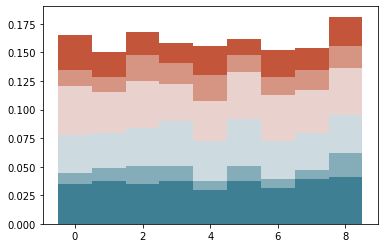

In [45]:
fig, ax = plt.subplots()
bottom=np.zeros(np.unique(clusterResAll).size+1)
for c in range(1,plotRes.shape[1]):
    ax.bar(np.arange(np.unique(clusterResAll).size+1),plotRes[:,c],bottom=bottom,color=np.array(sns.diverging_palette(220, 20, n=6))[c-1],width=1)
    bottom+=plotRes[:,c]
plt.savefig(os.path.join(plotsavepath,'errorsAll.pdf'))